<a href="https://colab.research.google.com/github/kolovratgas/HPC_labs/blob/main/lab4/S%26P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import numba
from matplotlib import pyplot as plt
from numba import cuda
import math
from time import time
from PIL import Image
from google.colab import files
from io import BytesIO

Saving sp_img2.jpg to sp_img2 (1).jpg


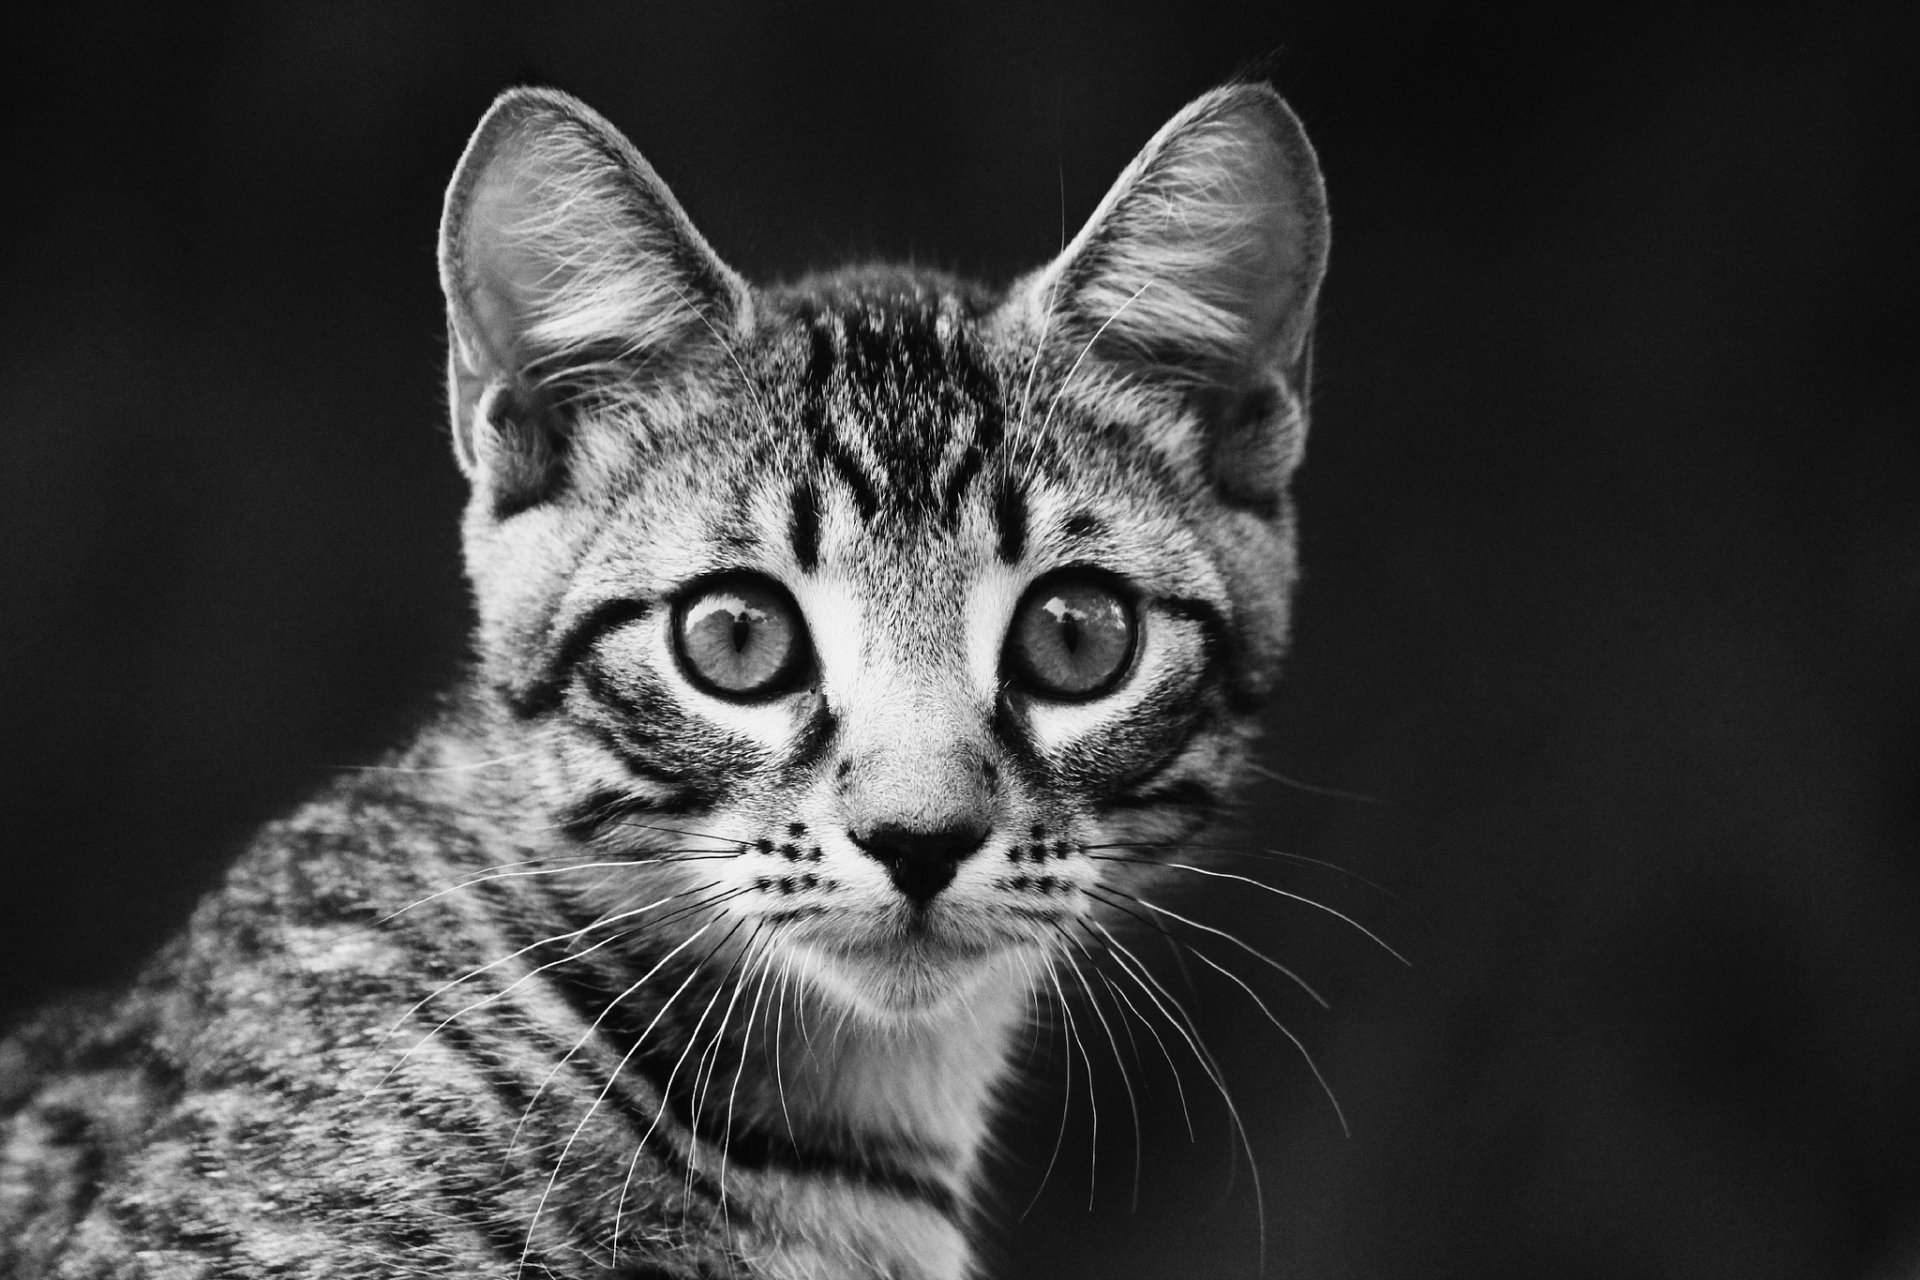

In [18]:
uploaded = files.upload()
img = Image.open(BytesIO(uploaded['sp_img2.jpg']))
img

In [19]:
def add_salt_and_pepper(image, prob):
  rnd = np.random.rand(image.shape[0], image.shape[1])
  noisy = image.copy()
  noisy[rnd < prob] = 0 
  noisy[rnd > 1 - prob] = 255
  return noisy 

In [20]:
def median_filter(a): 
  b = a.copy() 
  start = time()
  for i in range(2, len(a)-1):
    for j in range(2, len(a[i])-1):
      t=[0, 0, 0, 0, 0, 0, 0, 0, 0]
      t[0], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8] = a[i-1][j-1], a[i-1][j], a[i-1][j+1], a[i][j-1], a[i][j], a[i][j+1], a[i+1][j-1], a[i+1][j], a[i+1][j+1]
      for k in range(8): 
        for l in range(8-k):
          if t[l]>t[l+1]:
            t[l], t[l+1] = t[l+1], t[l]
      b[i][j]=t[(int)(len(t)/2)] 
  return b, time()-start

In [21]:
@cuda.jit
def gpu_median_filter(a, b):
  i, j = cuda.grid(2)
  t=cuda.local.array(shape=9, dtype=numba.int64)
  t[0], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8] = a[i-1][j-1], a[i-1][j], a[i-1][j+1], a[i][j-1], a[i][j], a[i][j+1], a[i+1][j-1], a[i+1][j], a[i+1][j+1]
  for k in range(8):
    for l in range(8-k):
      if t[l]>t[l+1]:
        t[l], t[l+1] = t[l+1], t[l]
  b[i][j]=t[(int)(len(t)/2)]

In [22]:
def prepare_and_exec_gpu(a):
  b = a.copy()
  tread_number_block = 32

  a_global = cuda.to_device(a)
  b_global = cuda.to_device(b)    
  threadsperblock = (tread_number_block, tread_number_block)
  blockspergrid_x = int(math.ceil(a.shape[0] / threadsperblock[1]))
  blockspergrid_y = int(math.ceil(b.shape[1] / threadsperblock[0]))
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  start = time()
  gpu_median_filter[blockspergrid, threadsperblock](a_global, b_global)
  return b_global.copy_to_host(), time()-start

In [26]:
def experiment(img_name, need_draw):
  im=(Image.open('sp_img2.jpg')).convert('L')
  if need_draw==True:
    display(im)
  img = np.array(im)

  img = add_salt_and_pepper(img, 0.09)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img)))

  img2, ctime = median_filter(img)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img2)))

  img2, gtime = prepare_and_exec_gpu(img)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img2)))
  
  n=len(img)*len(img[0])
  print('количество пикселей:', n)
  print('cpu time', ctime)
  print('gpu time', gtime)
  print('ускорение', ctime/gtime)
  print()
  return ctime/gtime, n

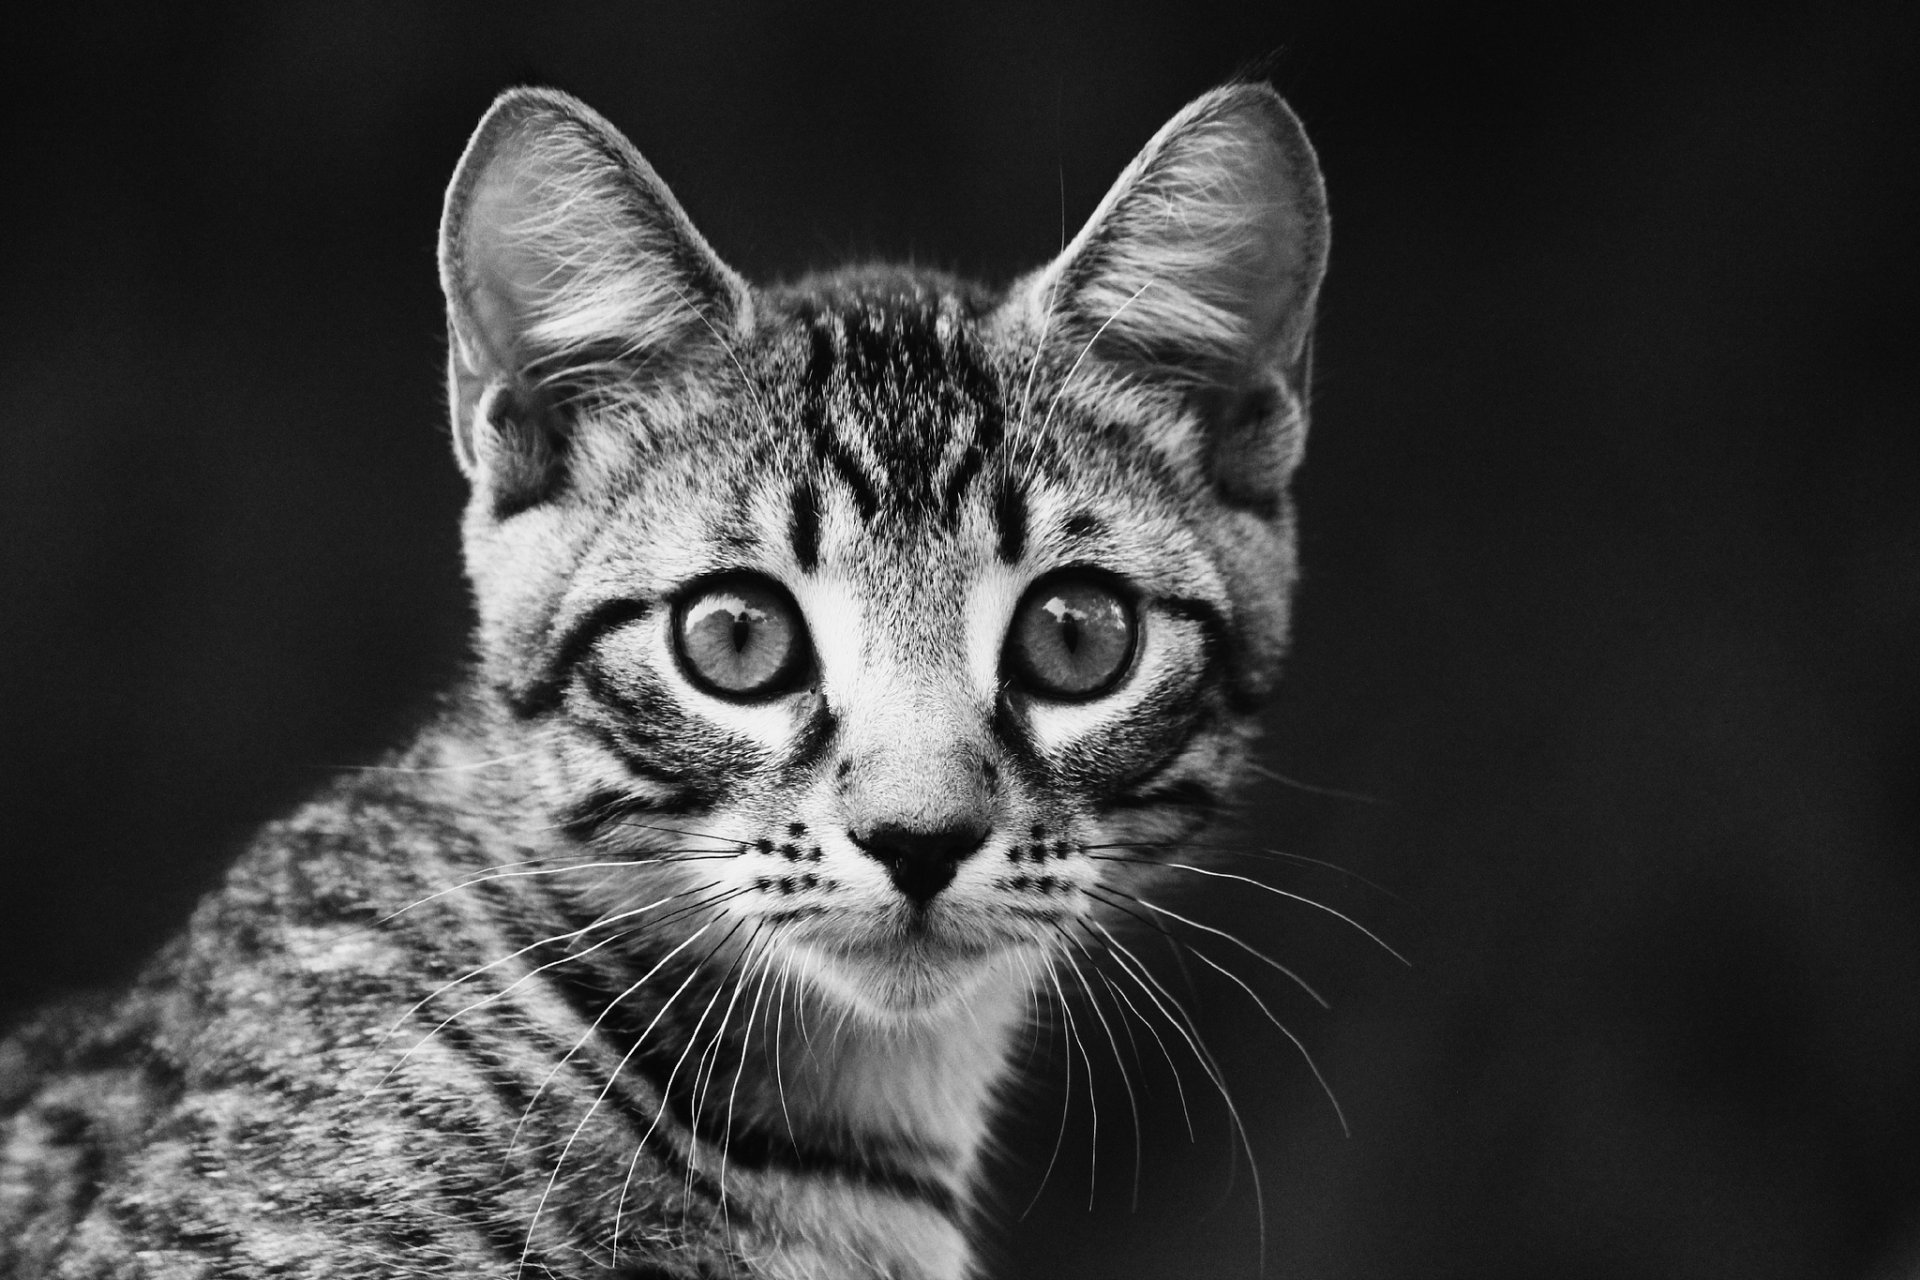

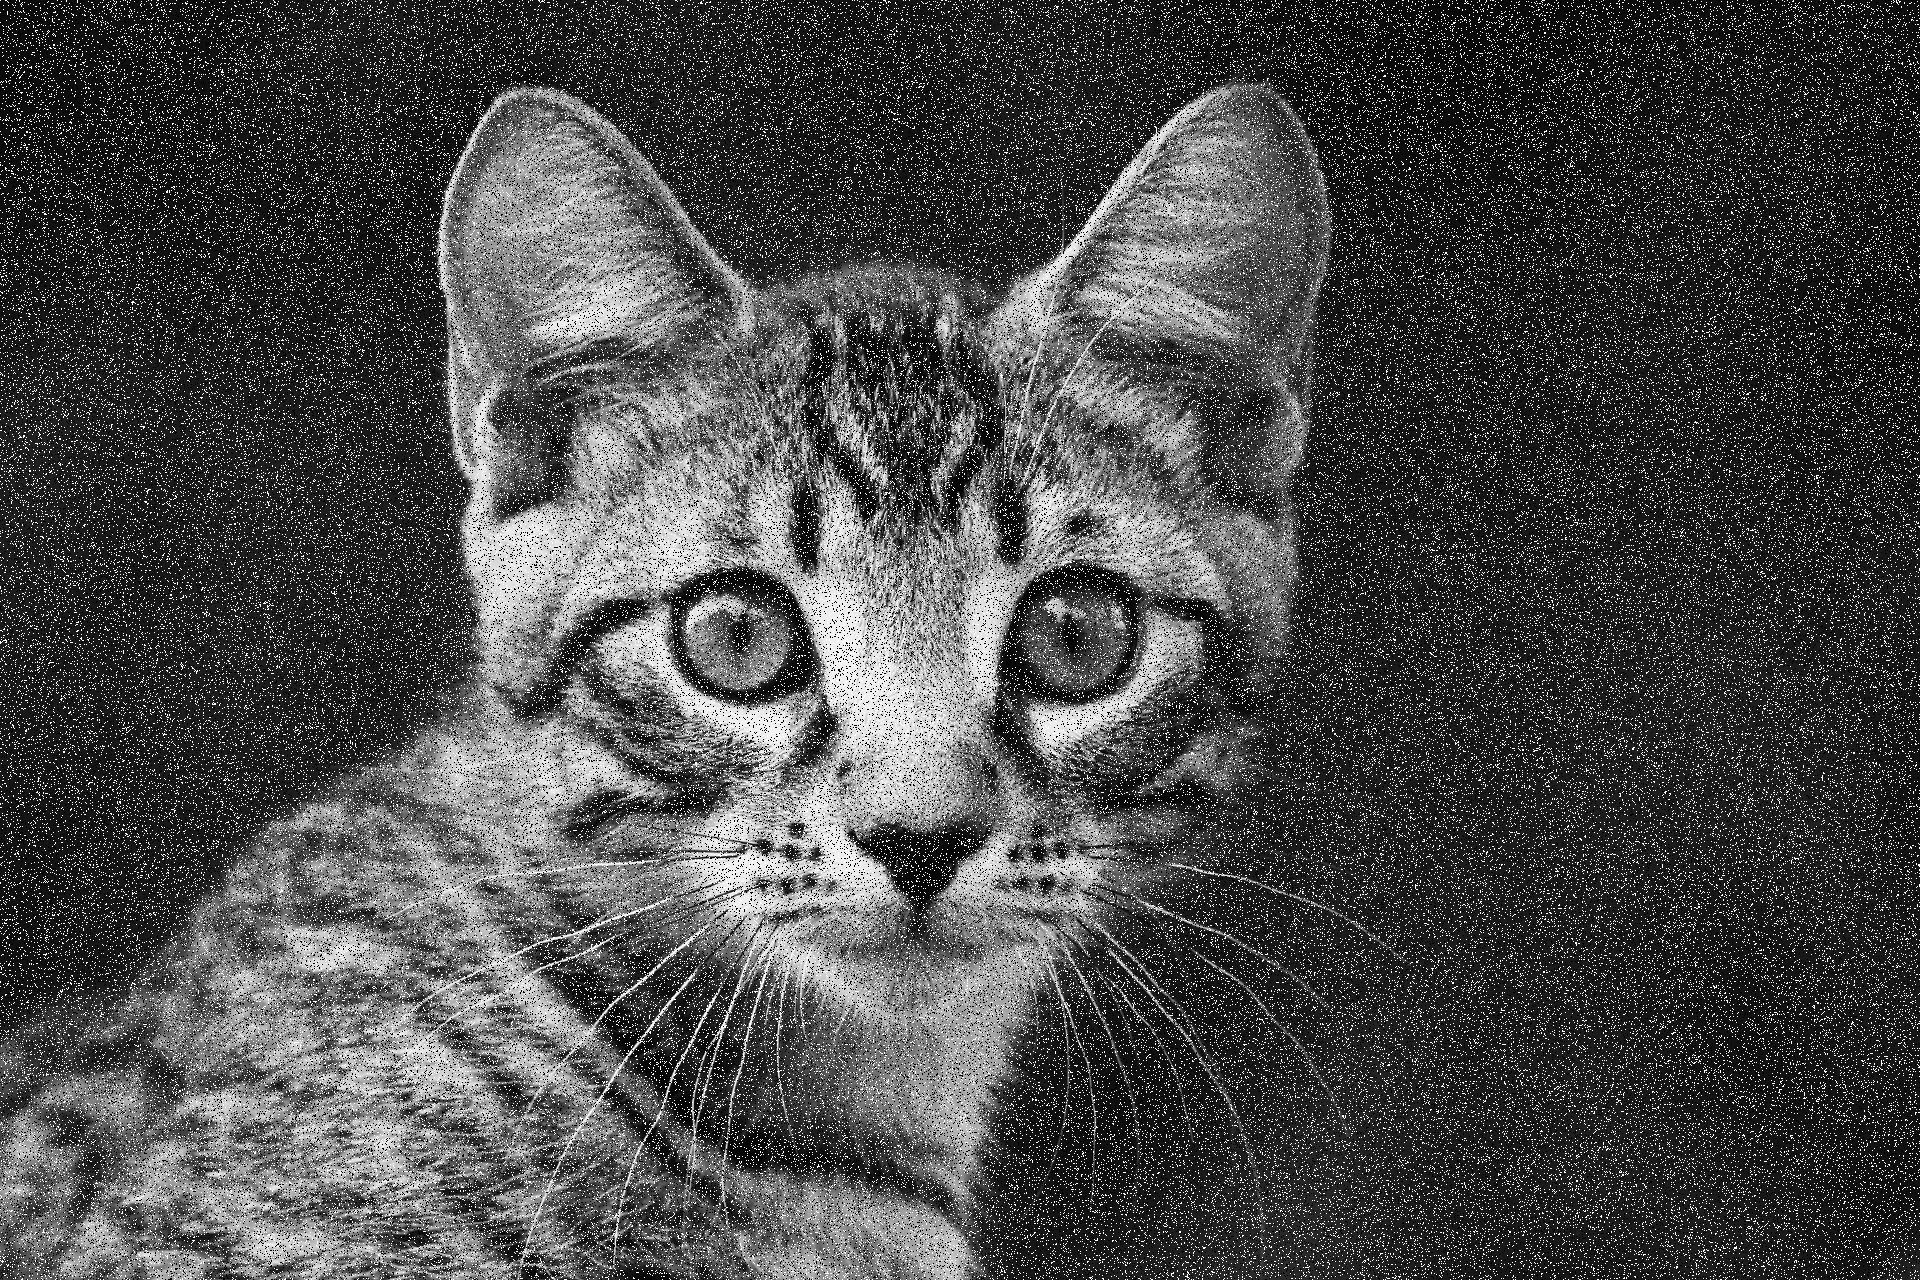

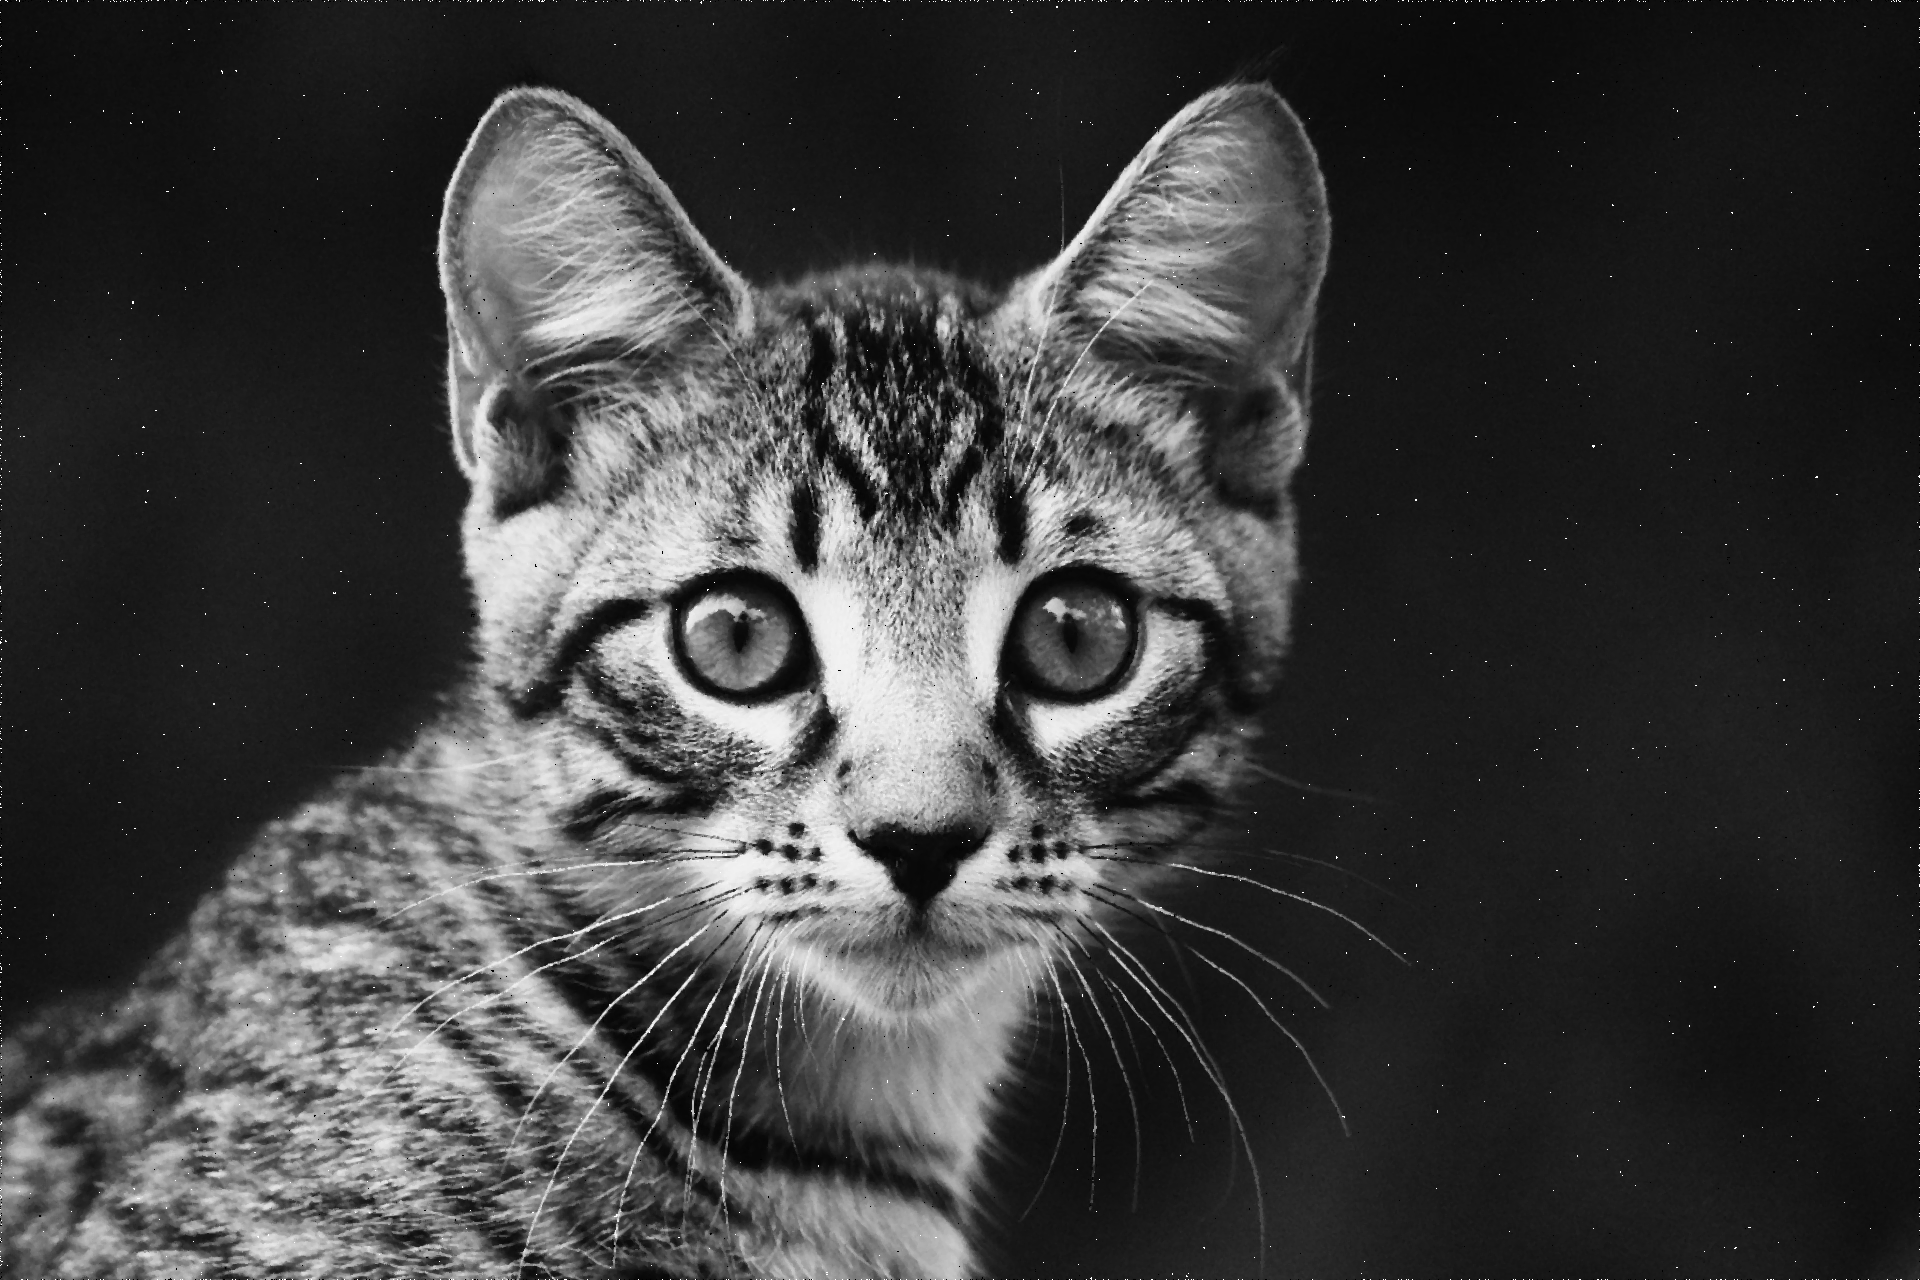

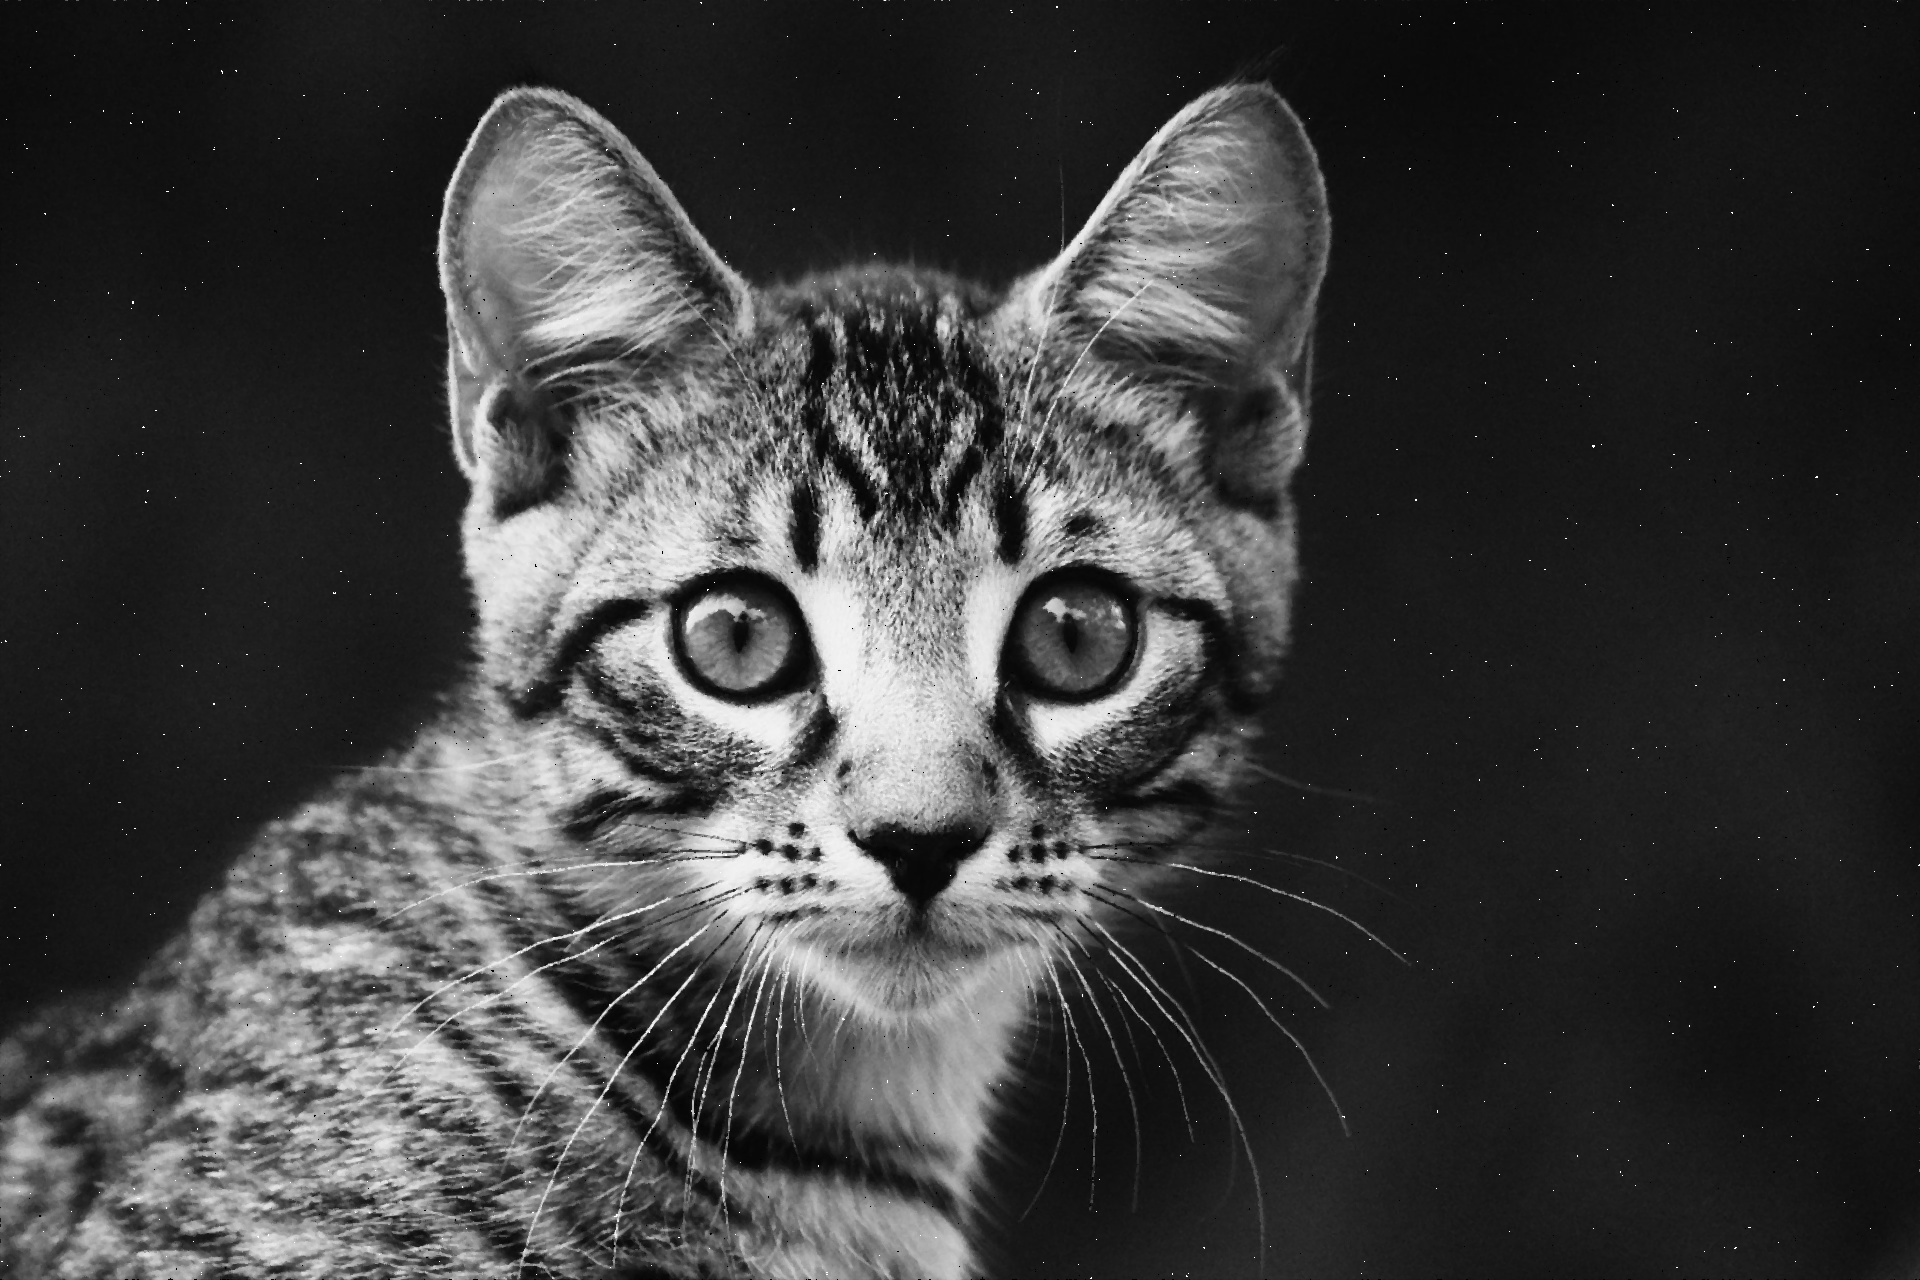

количество пикселей: 2457600
cpu time 34.194772481918335
gpu time 0.008298635482788086
ускорение 4120.529519924153



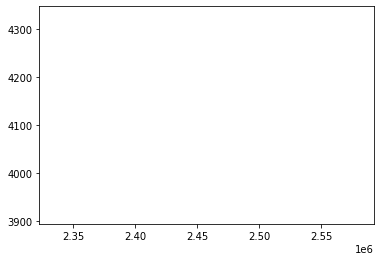

In [27]:
a1, n1 = experiment('sp_img2.jpg', True)

plt.plot([n1], [a1])
plt.show()